# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

Мы будем использовать [данные](https://archive.ics.uci.edu/ml/datasets/Adult) переписи населения США в 1994 году.

Выборка содержит 32561 наблюдение и 13 переменных, одна из которых — целевая (income). Все объекты были предварительно распределены на обучающую и тестовую части размерами 24420 и 8141 соответственно.

## Загрузка библиотек

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [213]:
! pip install comet_ml

Defaulting to user installation because normal site-packages is not writeable


In [214]:
from comet_ml import Experiment

In [215]:
#@title CometML set up
from comet_ml import Experiment

# experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)
experiment = Experiment(
  api_key = "ycRWmNIyeskpU0c3NsJBU44rG",
  project_name = "income-predict",
  workspace="lidiya-cutie",
  log_code=True
)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/lidiya-cutie/income-predict/ad5aab31eed84fcdbf5553fa6cf91615
COMET INFO:   Metrics:
COMET INFO:     Accuracy LE data     : 0.8044466281783564
COMET INFO:     Accuracy OneHot data : 0.8420341481390493
COMET INFO:     roc_auc OneHot data  : 0.885
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     categories        : auto
COMET INFO:     class_weight      : 1
COMET INFO:     drop              : 1
COMET INFO:     dtype             : <class 'numpy.float64'>
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     handle_unknown    : error
COMET INFO:     interce

## Загрузка данных

In [216]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [217]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [218]:
training_data.head(3)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0


Мы видим, что наши данные состоят как из числовых, так и из категориальных признаков.



Проверим размерности наших файлов:

In [219]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [220]:
# выделяем целевую переменную в отдельную переменную
target_name = 'income'

In [221]:
# отделим столбец 'income' в ниших данных

y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [222]:
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [223]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=dd2850674d3242659cf68ca654335064&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=dd2850674d3242659cf68ca654335064&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'imageId': 'dd2850674d3242659cf68ca654335064'}

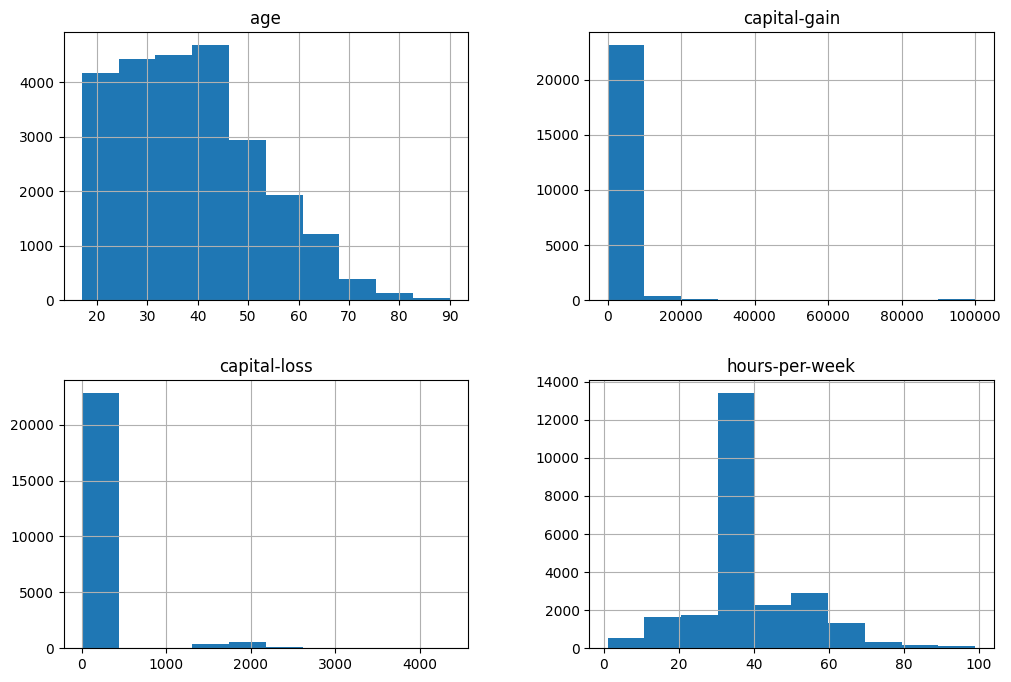

In [224]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [225]:
# Hаличие пропусков
X_train.isnull().mean()

age               0.000000
workclass         0.049017
education         0.040008
marital-status    0.000000
occupation        0.000000
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.029279
capital-loss      0.019820
hours-per-week    0.000000
native-country    0.000000
dtype: float64

In [226]:
# Проверка типов переменных
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [227]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [228]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [229]:
str(X_train['workclass'].value_counts(True).head(1))

'Private    0.696766\nName: workclass, dtype: float64'

In [230]:
str(X_train['education'].value_counts(True).head(1))

'HS-grad    0.322484\nName: education, dtype: float64'

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [231]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [232]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [233]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [234]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [235]:
from sklearn.preprocessing import LabelEncoder

In [236]:
label_encoder = LabelEncoder()

In [237]:
X_train_le = X_train.copy()

In [238]:
X_test_le = X_test.copy()

In [239]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [240]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [241]:
from sklearn.preprocessing import OneHotEncoder

In [242]:
onehot_encoder = OneHotEncoder()

In [243]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [244]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [245]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [246]:
X_train_new.head(3)

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [247]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [248]:
linear_model = LogisticRegression()

In [249]:
linear_model_oh = LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [250]:
linear_model_oh.fit(X_train_new, y_train)

C:\Users\Lida\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [251]:
linear_model.fit(X_train_le, y_train)

C:\Users\Lida\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Валидация модели на тестовой выборке

In [252]:
prediction_oh = linear_model_oh.predict(X_test_new)

In [253]:
prediction_le = linear_model.predict(X_test_le)

In [254]:
np.unique(prediction_oh)

array([0, 1], dtype=int64)

In [255]:
# Сколько 1го класса присутсвует в предсказаниях?
pred_1 = round((sum(prediction_oh) / len(prediction_oh)), 3) * 100
print(f'{pred_1} %')

19.6 %


In [256]:
# Сколько 1го класса присутсвует в y_test?
pred_y_test = round((sum(y_test) / len(y_test)), 3) * 100
print(f'{pred_y_test} %')

23.7 %


Данаая попытка проверки точности весьма и весьма условна и не дает уверенности в проведенном исследовании.

## Точность предсказания

Воспользуемся определенной метрикой для предсказания, например 'accuracy_score'

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [257]:
from sklearn.metrics import accuracy_score

In [258]:
acc_oh = accuracy_score(y_test, prediction_oh)
print(f'{round(acc_oh, 3) * 100} %')

84.2 %


In [259]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [260]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3) * 100, '%')

Accuracy Major Class:  76.3 %


In [261]:
# Залогировать accuracy для LE
acc_le = accuracy_score(y_test, prediction_le)
acc_le

0.8044466281783564

In [262]:
experiment.log_metric('Accuracy LE data', acc_le)

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [263]:
from sklearn.metrics import confusion_matrix

In [264]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5738,476
1,810,1117


In [265]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=e3d82f5352c64ff0b6e790b160429848&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=e3d82f5352c64ff0b6e790b160429848&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'assetId': 'e3d82f5352c64ff0b6e790b160429848'}

## Прогноз вероятности принадлежности к классу

In [266]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [278]:
# Как выглядят предсказания?
pred_proba_oh

array([[0.94577181, 0.05422819],
       [0.51756397, 0.48243603],
       [0.22021005, 0.77978995],
       ...,
       [0.98568201, 0.01431799],
       [0.4583828 , 0.5416172 ],
       [0.34429168, 0.65570832]])

In [268]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'web': 'https://www.comet.com/api/image/download?imageId=502245ba8c0c455ca974158b9dd69c7f&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=502245ba8c0c455ca974158b9dd69c7f&experimentKey=f51a222cb9d548da8ab7d3ca6e821b83',
 'imageId': '502245ba8c0c455ca974158b9dd69c7f'}

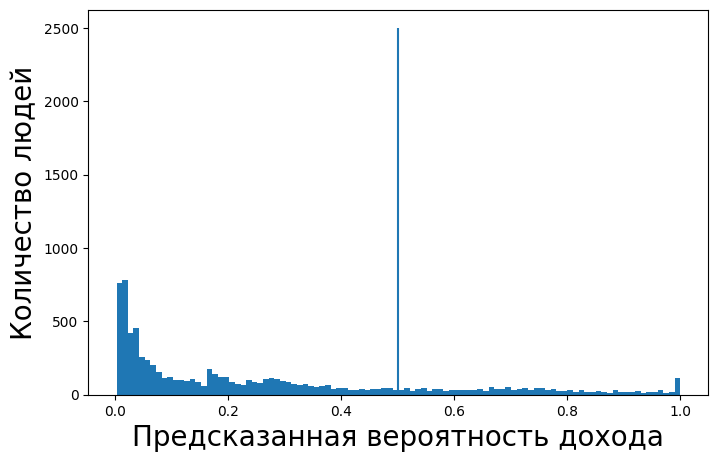

In [269]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [270]:
from sklearn.metrics import roc_curve

In [271]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

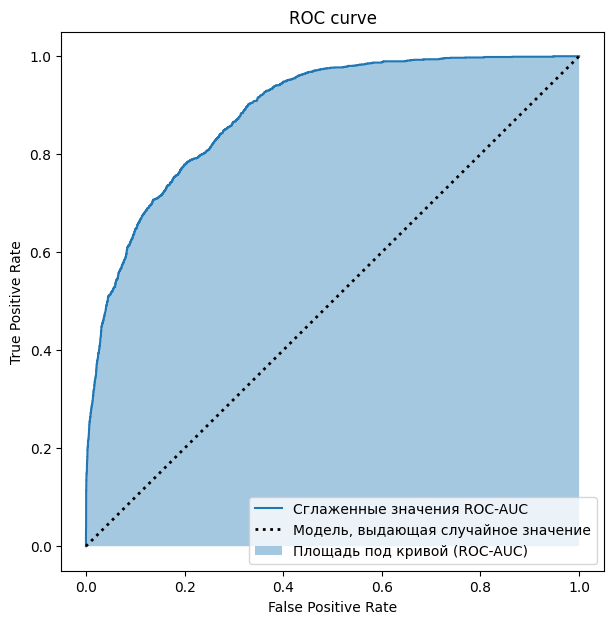

In [272]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [273]:
from sklearn.metrics import roc_auc_score

In [274]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [275]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.885


In [276]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [282]:
pred_proba_le = linear_model.predict_proba(X_test_le)

In [283]:
pred_proba = pred_proba_le[:, 1]

In [284]:
roc_auc_le = roc_auc_score(y_test, pred_proba).round(3)
roc_auc_le

0.785

In [285]:
experiment.log_metric('roc_auc LE data', roc_auc_le)

Наконец, давайте завершим наш эксперимент и закроем соединение с Comet.

In [286]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/lidiya-cutie/income-predict/f51a222cb9d548da8ab7d3ca6e821b83
COMET INFO:   Metrics:
COMET INFO:     Accuracy LE data     : 0.8044466281783564
COMET INFO:     Accuracy OneHot data : 0.8420341481390493
COMET INFO:     roc_auc LE data      : 0.785
COMET INFO:     roc_auc OneHot data  : 0.885
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     categories        : auto
COMET INFO:     class_weight      : 1
COMET INFO:     drop              : 1
COMET INFO:     dtype             : <class 'numpy.float64'>
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     hand

Какие выводы можно сделать по итогам данного эксперимента?

* Использовали методы заполнения пропусков
* Обучили модель методом логистической регрессии
* Выяснили, что логистическая регрессия - алгоритм, который чувствителен к методам кодировки
* Выбросы, которые присутствуют в наших данных, влияют на качество модели.